In [1]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
# 获取可用的 GPU 设备列表
# gpus = tf.config.experimental.list_physical_devices('GPU')

In [2]:
# 定义超参数
lr = 0.001
batch_size = 256
num_epochs = 100

In [3]:
# 定义卷积神经网络模型
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', input_shape=(32, 32, 3)), # 输入通道数为3，输出通道数为64，卷积核大小为3x3，填充为1
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.001)), # 输入通道数为64，输出通道数为64，卷积核大小为3x3，填充为1
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2), # 最大池化层，大小为2x2，步幅为2
    tf.keras.layers.Dropout(0.05),
    
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'), # 输入通道数为64，输出通道数为128，卷积核大小为3x3，填充为1
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)), # 输入通道数为128，输出通道数为128，卷积核大小为3x3，填充为1
    tf.keras.layers.BatchNormalization(),
    # 设置 kernel_regularizer 参数来实现 L2 正则化。其中 0.001 是 L2 正则化系数。
    tf.keras.layers.MaxPooling2D(2, 2), # 最大池化层，大小为2x2，步幅为2
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'), # 输入通道数为128，输出通道数为256，卷积核大小为3x3，填充为1
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)), # 输入通道数为256，输出通道数为256，卷积核大小为3x3，填充为1
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2), # 最大池化层，大小为2x2，步幅为2
    tf.keras.layers.Dropout(0.15),
    
    tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2), 
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2), 
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(), # 将张量展开为一维张量
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation='relu'), # 全连接层1，输入维度为256*4*4，输出维度为1024
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001)), # 全连接层2，输入维度为1024，输出维度为512
    tf.keras.layers.Dense(10, activation='softmax') # 输出层，输入维度为512，输出维度为10
])

2023-04-11 16:44:42.712822: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-11 16:44:42.722701: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-11 16:44:42.723012: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-11 16:44:42.724120: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [4]:
# 定义训练集和测试集的数据增强
train_transform = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

test_transform = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

In [5]:
# 读取模型
model = load_model('my_model_final_best.h5')

# 加载 CIFAR-10 数据集
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# 将标签转换为 one-hot 编码
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(lambda x, y: (test_transform(x), y))
test_dataset = test_dataset.batch(batch_size=batch_size)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)
#  让数据集对象 Dataset 在训练时预取出若干个元素，使得在 GPU 训练的同时 CPU 可以准备数据，从而提升训练流程的效率

# 进行测试
test_loss, test_acc = model.evaluate(test_dataset)
print('Test accuracy:', test_acc)

2023-04-11 16:44:48.106845: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


12/40 [========>.....................] - ETA: 0s - loss: 0.4821 - accuracy: 0.8896

2023-04-11 16:44:51.006335: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


40/40 [==============================] - 5s 18ms/step - loss: 0.4724 - accuracy: 0.8898
Test accuracy: 0.8898000121116638


In [6]:
# 打印神经网络各层名称
names = [layer.name for layer in model.layers]
print(names, len(names))

['conv2d', 'conv2d_1', 'batch_normalization', 'max_pooling2d', 'dropout', 'conv2d_2', 'conv2d_3', 'batch_normalization_1', 'max_pooling2d_1', 'dropout_1', 'conv2d_4', 'batch_normalization_2', 'conv2d_5', 'batch_normalization_3', 'conv2d_6', 'batch_normalization_4', 'max_pooling2d_2', 'dropout_2', 'conv2d_7', 'batch_normalization_5', 'conv2d_8', 'batch_normalization_6', 'conv2d_9', 'batch_normalization_7', 'max_pooling2d_3', 'dropout_3', 'conv2d_10', 'batch_normalization_8', 'conv2d_11', 'batch_normalization_9', 'conv2d_12', 'batch_normalization_10', 'max_pooling2d_4', 'dropout_4', 'flatten', 'dropout_5', 'dense', 'dropout_6', 'dense_1', 'dropout_7', 'dense_2', 'dense_3'] 42


In [6]:
# #打印神经网络结构
# for layer in model.layers:
#         for weight in layer.weights:
#             print(weight.name, weight.shape)

In [55]:
# 打印寻找最后一个卷积层
conv_layer = model.get_layer(name='conv2d_12')
conv_layer
print(conv_layer.name)
for weight in conv_layer.weights:
    print(weight.name, weight.shape)
# conv2d_12/kernel:0 (3, 3, 512, 512) 卷积核大小3*3 输入通道数512 输出通道数512

conv_layer = model.get_layer(index=-12)
print(conv_layer.name)
for weight in conv_layer.weights:
    print(weight.name, weight.shape)
    
conv_layer = model.get_layer(index=-20)
print(conv_layer.name)
for weight in conv_layer.weights:
    print(weight.name, weight.shape)

conv2d_12
conv2d_12/kernel:0 (3, 3, 512, 512)
conv2d_12/bias:0 (512,)
conv2d_12
conv2d_12/kernel:0 (3, 3, 512, 512)
conv2d_12/bias:0 (512,)
conv2d_9
conv2d_9/kernel:0 (3, 3, 512, 512)
conv2d_9/bias:0 (512,)


In [5]:
# # 显示特征图 参考代码
# def showFeatureMap(featureMap,k):
#     if not os.path.exists(rootPath):
#         os.mkdir(rootPath)
#     kPath = os.path.join(rootPath,str(k))
#     if not os.path.exists(kPath):
#         os.mkdir(kPath)
#     featureMap = featureMap. squeeze(0)
#     featureMapNum = featureMap.shape[0] #返回通道数
#     row_num = np.ceil(np.sqrt(featureMapNum))#将通道数开方取整，尽可能地使行列数相同
#     plt.figure()
#     for index in range(1,featureMapNum + 1):#通过遍历的方式，将每个特征图拿出
#         plt.subplot(row_num,row_num,index)
#         plt.imshow(featureMap[index - 1],cmap='gray')
#         plt.axis('off')
#         #保存特征图到指定的路径下
#         scipy.misc.imsave(os.path.join(kPath,str(index) + '.png'),featureMap[index - 1])#将这一层所有的特征图合并显示并保存
#     plt.savefig(os.path.join(kPath,'totImg.png' ))
#     plt.show()

In [7]:
last_conv_layer = model.layers[-12]
last_conv_layer_model = tf.keras.models.Model(model.inputs, last_conv_layer.output)
conv_outputs = last_conv_layer_model.predict(test_dataset)
# conv_outputs
average_output = tf.reduce_mean(conv_outputs, axis=0)
average_output

<tf.Tensor: shape=(2, 2, 512), dtype=float32, numpy=
array([[[0.35425472, 0.58658934, 0.16616865, ..., 0.3775052 ,
         0.253711  , 0.2337245 ],
        [0.18189467, 0.7158923 , 0.04594743, ..., 0.49970454,
         0.44316137, 0.65379816]],

       [[0.5165768 , 0.41051158, 0.18278298, ..., 0.20512286,
         0.19628273, 0.5447516 ],
        [0.13349736, 0.39791712, 0.3625206 , ..., 0.1542081 ,
         0.47224835, 0.23300618]]], dtype=float32)>

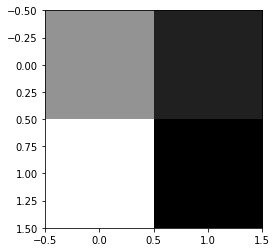

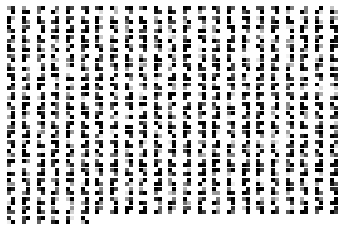

In [8]:
# 打印最后一层卷积层（剪枝前） 在整个测试数据集上的平均输出特征图
plt.imshow(average_output[:,:,0], cmap='gray') #打印第0张平均输出特征图
plt.show()
# plt.imshow(average_output[:,:,1], cmap='gray')
# plt.show()
row_num = int(np.ceil(np.sqrt(average_output.shape[2])))#将通道数开方取整，尽可能地使行列数相同
row_num
for index in range(1,average_output.shape[2]+1):#通过遍历的方式，将每个特征图拿出
    plt.subplot(row_num,row_num,index)
    plt.imshow(average_output[:,:,index-1],cmap='gray')
    plt.axis('off')
plt.show()

In [9]:
# 对平均激活值进行排序
average_activations = tf.reduce_mean(conv_outputs, axis=(0,1,2)) # 计算每个神经元在整个测试数据集上的平均激活值
sorted_indices = tf.argsort(average_activations, direction='ASCENDING') # 对平均激活值进行排序
for i in range(len(sorted_indices)): #打印排序后的神经元及其对应的平均激活值
    print(f"Neuron {sorted_indices[i]}: {average_activations[sorted_indices[i]]}")
    # 打印观察每个神经元在整个测试数据集上的平均激活值

Neuron 236: 0.03269832581281662
Neuron 383: 0.05992547422647476
Neuron 125: 0.07034046947956085
Neuron 491: 0.08466646820306778
Neuron 218: 0.08590062707662582
Neuron 92: 0.08756137639284134
Neuron 380: 0.10096488893032074
Neuron 427: 0.10129434615373611
Neuron 104: 0.10306920111179352
Neuron 454: 0.10644809901714325
Neuron 61: 0.10692503303289413
Neuron 336: 0.11001578718423843
Neuron 250: 0.11110815405845642
Neuron 172: 0.11362634599208832
Neuron 307: 0.11739332228899002
Neuron 148: 0.12002052366733551
Neuron 247: 0.12507620453834534
Neuron 198: 0.12552356719970703
Neuron 419: 0.12754957377910614
Neuron 42: 0.1288086473941803
Neuron 311: 0.12914273142814636
Neuron 77: 0.1298746019601822
Neuron 75: 0.13046099245548248
Neuron 471: 0.1351509839296341
Neuron 470: 0.13604474067687988
Neuron 296: 0.1363120824098587
Neuron 404: 0.1368200033903122
Neuron 95: 0.1377684772014618
Neuron 240: 0.13837897777557373
Neuron 98: 0.1384437531232834
Neuron 90: 0.1385039985179901
Neuron 189: 0.1391487419

In [10]:
# # 单次剪枝代码
# sorted_indices = tf.argsort(average_activations, direction='ASCENDING') # 对平均激活值进行排序 argsort函数返回的是数组值从小到大的索引值
# # sorted_indices
# # len(sorted_indices)
# K = 1 # 要剪枝的神经元数
# last_conv_layer = model.layers[-12]
# weights, biases = last_conv_layer.get_weights()
# for i in range(0, K):
#     neuron_index = sorted_indices[i]
#     weights[:,:,:,neuron_index] = 0 # 将该神经元的权重设为0
#     biases[neuron_index] = 0 # 将该神经元的偏置设为0
# last_conv_layer.set_weights([weights, biases]) # 更新最后一层卷积层的权重和偏置

In [11]:
# #检测权重是否被修改
# last_conv_layer = model.layers[-12]
# last_conv_layer_model = tf.keras.models.Model(model.inputs, last_conv_layer.output)
# conv_outputs = last_conv_layer_model.predict(test_dataset)
# # conv_outputs
# average_activations = tf.reduce_mean(conv_outputs, axis=(0,1,2)) # 计算每个神经元在整个测试数据集上的平均激活值
# sorted_indices = tf.argsort(average_activations, direction='ASCENDING') # 对平均激活值进行排序
# for i in range(len(sorted_indices)): #打印排序后的神经元及其对应的平均激活值
#     print(f"Neuron {sorted_indices[i]}: {average_activations[sorted_indices[i]]}")

Neuron 236: 0.0
Neuron 383: 0.05992547422647476
Neuron 125: 0.07034046947956085
Neuron 491: 0.08466646820306778
Neuron 218: 0.08590062707662582
Neuron 92: 0.08756137639284134
Neuron 380: 0.10096488893032074
Neuron 427: 0.10129434615373611
Neuron 104: 0.10306920111179352
Neuron 454: 0.10644809901714325
Neuron 61: 0.10692503303289413
Neuron 336: 0.11001578718423843
Neuron 250: 0.11110815405845642
Neuron 172: 0.11362634599208832
Neuron 307: 0.11739332228899002
Neuron 148: 0.12002052366733551
Neuron 247: 0.12507620453834534
Neuron 198: 0.12552356719970703
Neuron 419: 0.12754957377910614
Neuron 42: 0.1288086473941803
Neuron 311: 0.12914273142814636
Neuron 77: 0.1298746019601822
Neuron 75: 0.13046099245548248
Neuron 471: 0.1351509839296341
Neuron 470: 0.13604474067687988
Neuron 296: 0.1363120824098587
Neuron 404: 0.1368200033903122
Neuron 95: 0.1377684772014618
Neuron 240: 0.13837897777557373
Neuron 98: 0.1384437531232834
Neuron 90: 0.1385039985179901
Neuron 189: 0.1391487419605255
Neuron 16

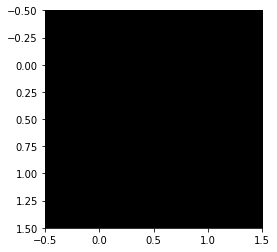

In [12]:
# #检测权重是否已经被修改
# last_conv_layer = model.layers[-12]
# last_conv_layer_model = tf.keras.models.Model(model.inputs, last_conv_layer.output)
# conv_outputs = last_conv_layer_model.predict(test_dataset)
# average_output = tf.reduce_mean(conv_outputs, axis=0)
# average_output
# plt.imshow(average_output[:,:,236], cmap='gray')
# plt.show()

In [13]:
accuracies = [] # 创建数组记录预测准确率变化
# for i in range(0,5):
for i in range(0,average_output.shape[2]):
    K = i # 要剪枝的神经元数
    last_conv_layer = model.layers[-12]
    last_conv_layer_model = tf.keras.models.Model(model.inputs, last_conv_layer.output)
    conv_outputs = last_conv_layer_model.predict(test_dataset)
    weights, biases = last_conv_layer.get_weights()
    average_activations = tf.reduce_mean(conv_outputs, axis=(0,1,2)) # 计算每个神经元在整个测试数据集上的平均激活值
    sorted_indices = tf.argsort(average_activations, direction='ASCENDING') # 对平均激活值进行排序
    for j in range(0, K):
#         print('j:', j)
        neuron_index = sorted_indices[j]
        weights[:,:,:,neuron_index] = 0 # 将该神经元的权重设为0
        biases[neuron_index] = 0 # 将该神经元的偏置设为0
    last_conv_layer.set_weights([weights, biases]) # 更新最后一层卷积层的权重和偏置
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # 进行测试
    _, accuracy = model.evaluate(test_dataset, verbose=0)
    accuracies.append(accuracy)
    print(f'k={K}, accuracy={accuracy}')
#     sorted_indices = tf.argsort(average_activations, direction='ASCENDING') # 对平均激活值进行排序
#     for i in range(0,10): #打印排序后的神经元及其对应的平均激活值
#         print(f"Neuron {sorted_indices[i]}: {average_activations[sorted_indices[i]]}")
    print('K:', K)

k=0, accuracy=0.8898000121116638
K: 0
k=1, accuracy=0.8898000121116638
K: 1
k=2, accuracy=0.8898000121116638
K: 2
k=3, accuracy=0.8898000121116638
K: 3
k=4, accuracy=0.8898000121116638
K: 4
k=5, accuracy=0.8898000121116638
K: 5
k=6, accuracy=0.8898000121116638
K: 6
k=7, accuracy=0.8895999789237976
K: 7
k=8, accuracy=0.8895999789237976
K: 8
k=9, accuracy=0.8895999789237976
K: 9
k=10, accuracy=0.8895000219345093
K: 10
k=11, accuracy=0.8895999789237976
K: 11
k=12, accuracy=0.8895000219345093
K: 12
k=13, accuracy=0.8898000121116638
K: 13
k=14, accuracy=0.8898000121116638
K: 14
k=15, accuracy=0.8895999789237976
K: 15
k=16, accuracy=0.8895999789237976
K: 16
k=17, accuracy=0.8894000053405762
K: 17
k=18, accuracy=0.8896999955177307
K: 18
k=19, accuracy=0.8895000219345093
K: 19
k=20, accuracy=0.8896999955177307
K: 20
k=21, accuracy=0.8902000188827515
K: 21
k=22, accuracy=0.8899999856948853
K: 22
k=23, accuracy=0.8899999856948853
K: 23
k=24, accuracy=0.8902999758720398
K: 24
k=25, accuracy=0.889

In [15]:
# # 用于检测权重是否被修改
# average_activations = tf.reduce_mean(conv_outputs, axis=(0,1,2)) # 计算每个神经元在整个测试数据集上的平均激活值
# sorted_indices = tf.argsort(average_activations, direction='ASCENDING') # 对平均激活值进行排序
# for i in range(len(sorted_indices)): #打印排序后的神经元及其对应的平均激活值
#     print(f"Neuron {sorted_indices[i]}: {average_activations[sorted_indices[i]]}")

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# 进行测试
_, accuracy = model.evaluate(test_dataset, verbose=0)
print(f'k={K}, accuracy={accuracy}')

k=511, accuracy=0.10000000149011612


In [15]:
# # # 用于检测权重是否被修改
# last_conv_layer = model.layers[-12]
# last_conv_layer_model = tf.keras.models.Model(model.inputs, last_conv_layer.output)
# conv_outputs = last_conv_layer_model.predict(test_dataset)
# # #用于检测权重是否被修改
# average_activations = tf.reduce_mean(conv_outputs, axis=(0,1,2)) # 计算每个神经元在整个测试数据集上的平均激活值
# sorted_indices = tf.argsort(average_activations, direction='ASCENDING') # 对平均激活值进行排序
# for i in range(len(sorted_indices)): #打印排序后的神经元及其对应的平均激活值
#     print(f"Neuron {sorted_indices[i]}: {average_activations[sorted_indices[i]]}")

Neuron 0: 0.0
Neuron 1: 0.0
Neuron 2: 0.0
Neuron 3: 0.0
Neuron 4: 0.0
Neuron 5: 0.0
Neuron 6: 0.0
Neuron 7: 0.0
Neuron 8: 0.0
Neuron 9: 0.0
Neuron 10: 0.0
Neuron 11: 0.0
Neuron 12: 0.0
Neuron 13: 0.0
Neuron 14: 0.0
Neuron 15: 0.0
Neuron 16: 0.0
Neuron 17: 0.0
Neuron 18: 0.0
Neuron 19: 0.0
Neuron 20: 0.0
Neuron 21: 0.0
Neuron 22: 0.0
Neuron 23: 0.0
Neuron 24: 0.0
Neuron 25: 0.0
Neuron 26: 0.0
Neuron 27: 0.0
Neuron 28: 0.0
Neuron 29: 0.0
Neuron 30: 0.0
Neuron 31: 0.0
Neuron 32: 0.0
Neuron 33: 0.0
Neuron 34: 0.0
Neuron 35: 0.0
Neuron 36: 0.0
Neuron 37: 0.0
Neuron 38: 0.0
Neuron 39: 0.0
Neuron 40: 0.0
Neuron 41: 0.0
Neuron 42: 0.0
Neuron 43: 0.0
Neuron 44: 0.0
Neuron 45: 0.0
Neuron 46: 0.0
Neuron 47: 0.0
Neuron 48: 0.0
Neuron 49: 0.0
Neuron 50: 0.0
Neuron 51: 0.0
Neuron 52: 0.0
Neuron 53: 0.0
Neuron 54: 0.0
Neuron 55: 0.0
Neuron 56: 0.0
Neuron 57: 0.0
Neuron 58: 0.0
Neuron 59: 0.0
Neuron 60: 0.0
Neuron 61: 0.0
Neuron 62: 0.0
Neuron 63: 0.0
Neuron 64: 0.0
Neuron 65: 0.0
Neuron 66: 0.0
Neuro

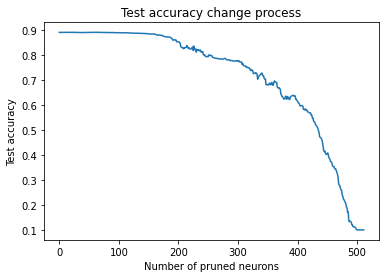

In [16]:
plt.plot(range(0, average_output.shape[2]), accuracies)
plt.xlabel('Number of pruned neurons')
plt.ylabel('Test accuracy')
plt.title('Test accuracy change process')
plt.show()